In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 10
nA = 2
seed = get_current_seed()
seed = 47146882006333120128184314011326542902
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Current seed for result reproducibility: 216233222354555103707489317002712972996


In [2]:
theta_1 = np.random.rand(nS, nA)
theta_2 = np.random.rand(nS, nA)
pi_1 = get_softmax_policy(theta_1)
pi_2 = get_softmax_policy(theta_2)

q = np.random.rand(nS, nA)*100

pi_1_tensor = torch.tensor(pi_1, dtype=torch.float32, device=device)
pi_2_tensor = torch.tensor(pi_2, dtype=torch.float32, device=device)
q_tensor = torch.tensor(q, dtype=torch.float32, device=device)
xi_tensor = torch.tensor(tmdp.xi, dtype=torch.float32, device=device)
P_mat_tensor = torch.tensor(tmdp.env.P_mat, dtype=torch.float32, device=device)
mu_tensor = torch.tensor(tmdp.env.mu, dtype=torch.float32, device=device)


start_time = time.time()
ap_t = compute_relative_policy_advantage_function(pi_1_tensor, pi_2_tensor, q_tensor)
end_time = time.time()
tensor_computation_time = end_time - start_time
print("Tensor computation time: ", tensor_computation_time)
start_time = time.time()
ap = compute_relative_policy_advantage_function(pi_1, pi_2, q)
end_time = time.time()
numpy_computation_time = end_time - start_time
print("Numpy computation time: ", numpy_computation_time)

print(ap_t)
print(ap)

Tensor computation time:  0.04300999641418457
Numpy computation time:  0.0
tensor([ 2.1130, -1.5560, -8.3485,  5.1632, 14.4870,  2.9214, -1.3856,  2.5640,
        -0.5633, -2.1164], device='cuda:0')
[ 2.11297685 -1.55604249 -8.34845778  5.16319328 14.48700047  2.9214281
 -1.38556792  2.56398139 -0.56332305 -2.11635846]


In [3]:

U = np.random.rand(nS, nA, nS)*100
U_tensor = torch.tensor(U, dtype=torch.float32, device=device)

start_time = time.time()
am_t = compute_relative_model_advantage_function(P_mat_tensor, xi_tensor, U_tensor)
end_time = time.time()
tensor_computation_time = end_time - start_time
print("Tensor computation time: ", tensor_computation_time)

start_time = time.time()
am = compute_relative_model_advantage_function(tmdp.env.P_mat, xi, U)
end_time = time.time()
numpy_computation_time = end_time - start_time
print("Numpy computation time: ", numpy_computation_time)
start_time = time.time()
print(ap_t.cpu().numpy())
end_time = time.time()
print("Tensor to numpy time: ", end_time - start_time)
print(ap)

Tensor computation time:  0.0
Numpy computation time:  0.0005080699920654297
[ 2.1129763 -1.556041  -8.348459   5.163192  14.4869995  2.9214282
 -1.3855684  2.563981  -0.5633228 -2.116357 ]
Tensor to numpy time:  0.0
[ 2.11297685 -1.55604249 -8.34845778  5.16319328 14.48700047  2.9214281
 -1.38556792  2.56398139 -0.56332305 -2.11635846]


In [4]:
d = compute_d_from_tau(tmdp.env.mu, tmdp.env.P_mat, tmdp.xi, pi_1, tmdp.gamma, tmdp.tau)

d_tens = compute_d_from_tau_tensor(mu_tensor, P_mat_tensor, xi_tensor, pi_1_tensor, gamma, tau, device)

print(d)
print(d_tens)

exp_ap = compute_expected_policy_advantage(ap, d)
exp_ap_tens = compute_expected_policy_advantage(ap_t, d_tens)
print(exp_ap)
print(exp_ap_tens)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000], device='cuda:0')
1.3278830390957275
1.3278824090957642


In [5]:
V = compute_V_from_Q(q, pi_1)
V_t = compute_V_from_Q(q_tensor, pi_1_tensor)
print(V)
print(V_t)

r_tensor = torch.tensor(tmdp.env.reward, dtype=torch.float32, device=device)
u_t = compute_U_from_V(r_tensor, tmdp.gamma, V_t)
print(u_t.cpu().numpy())

u = compute_U_from_V(tmdp.env.reward, tmdp.gamma, V)
print(u)

[24.52819177 41.14788246 46.76580474 25.65074761 45.9032139  57.52486527
 26.49671143 63.32797891 72.35206784 46.68129634]
tensor([24.5282, 41.1479, 46.7658, 25.6507, 45.9032, 57.5249, 26.4967, 63.3280,
        72.3521, 46.6813], device='cuda:0')
[[[  27.07537    37.033092   42.089222   23.085672   41.312893
     51.772377   23.84704    56.995182   65.11686    42.01317 ]
  [  22.07537    37.033092   42.089222   23.085672   41.312893
     51.772377   23.84704    56.995182   65.11686    42.01317 ]]

 [[  22.07537    37.033092   42.089222   23.085672   41.312893
     51.772377   23.84704    56.995182   65.11686    42.01317 ]
  [  22.07537    37.033092   42.089222   23.085672   41.312893
     51.772377   23.84704    56.995182   65.11686    42.01317 ]]

 [[  22.07537    37.033092   42.089222   23.085672   41.312893
     51.772377   23.84704    56.995182   65.11686    42.01317 ]
  [  22.07537    37.033092   42.089222   23.085672   41.312893
     51.772377   23.84704    56.995182   65.11686  

In [6]:
t_k = compute_transition_kernel(tmdp.env.P_mat, tmdp.xi, tmdp.tau, pi_1)
t_k_tensor = compute_transition_kernel(P_mat_tensor, xi_tensor, tmdp.tau, pi_1_tensor)

print(t_k)
print(t_k_tensor)

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0

In [7]:
q_c = np.zeros((nS, nA))
tmdp.update_tau(.99)
cur_res = curriculum_AC(tmdp, q_c, alpha = 0.02, alpha_pol = 0.01, episodes=18000000, batch_nS=128, temperature=20., biased=False, lam=0., epochs=10, use_delta_Q=False)


[(0.77645, 0.99), (0.0, 0.98946)]
Alpha*: 0.77645 tau*: 0.99 Episode: 14244 length: 129 #teleports:14116
Got not null reward 1025.0!
Time for bound evaluation:  0.003001689910888672
[(1, 0.99), (0.0, 0.98938), (1.0, 0.98964)]
Alpha*: 1.0 tau*: 0.98964 Episode: 27079 length: 129 #teleports:12706
Got not null reward 1025.0!
Time for bound evaluation:  0.0030012130737304688
[(1, 0.98964), (0.0, 0.98905), (1.0, 0.98937)]
Alpha*: 1.0 tau*: 0.98937 Episode: 39213 length: 131 #teleports:12003
Got not null reward 6050.0!
Time for bound evaluation:  0.004001140594482422
[(1, 0.98937), (0.0, 0.98868), (1.0, 0.98895)]
Alpha*: 1.0 tau*: 0.98895 Episode: 50673 length: 129 #teleports:11331
Got not null reward 2015.0!
Time for bound evaluation:  0.004000663757324219
[(1, 0.98895), (0.0, 0.98825), (1.0, 0.98858)]
Alpha*: 1.0 tau*: 0.98858 Episode: 63594 length: 128 #teleports:12793
Got not null reward 3025.0!
Time for bound evaluation:  0.008001089096069336
[(1, 0.98858), (0.0, 0.9879), (1.0, 0.9881)]

In [ ]:
print(get_softmax_policy(cur_res["thetas"][-1]))
print(cur_res["Qs"][-1])
print(get_policy(cur_res["Qs"][-1]))

[[0.58091818 0.41908182]
 [0.55989509 0.44010491]
 [0.5447339  0.4552661 ]
 [0.53109419 0.46890581]
 [0.51992437 0.48007563]
 [0.50772227 0.49227773]
 [0.48392721 0.51607279]
 [0.41681686 0.58318314]
 [0.25140853 0.74859147]
 [0.15250949 0.84749051]]
[[ 22.65083459  16.52782301]
 [ 17.41968095  13.33969586]
 [ 13.81161698  10.80091177]
 [ 10.98223471   8.46785959]
 [  8.77011399   6.96468283]
 [  7.06954606   6.26144441]
 [  5.99987728   8.49960619]
 [  6.54320082  21.61056316]
 [ 13.25866745  79.7840537 ]
 [ 46.98559077 389.92761251]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
res = bellman_optimal_q(mdp.env.P_mat, mdp.env.reward, mdp.gamma)
Q = res["Q"]

d = compute_d_from_tau(mdp.env.mu, mdp.env.P_mat, mdp.xi, get_policy(Q), mdp.gamma, 0.)
#d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(get_softmax_policy(cur_res["thetas"][-1])), tmdp.gamma, 0.)
d_q = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(q_c), tmdp.gamma, 0.)

#delta_pol = get_policy(Q)-get_policy(get_softmax_policy(cur_res["thetas"][-1]))
#print(delta_pol)
V = compute_V_from_Q(Q, get_softmax_policy(q_c))
r_s_a = compute_r_s_a(mdp.env.P_mat, mdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, mdp.gamma)
#j_curr = compute_j(r_s_a, get_policy(get_softmax_policy(cur_res["thetas"][-1])), d_curr, tmdp.gamma)
j_q_curr = compute_j(r_s_a, get_policy(q_c), d_q, tmdp.gamma)
j_exp = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)
print("expected performance: ",j_exp)
#print("curriculum performance: ", j_curr)
print("Q curriculum performance: ",j_q_curr)

optimal performance:  301.78608999693387
expected performance:  284.8585164226059
Q curriculum performance:  258.8514369993318


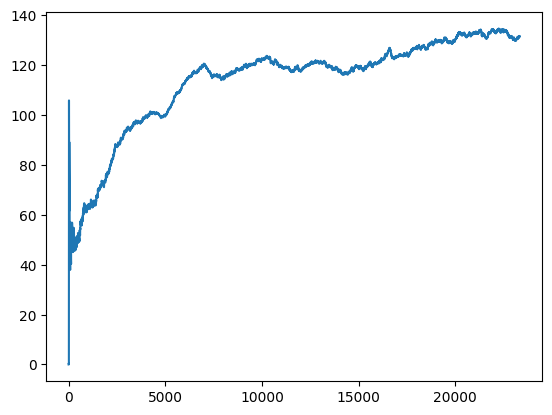

In [ ]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 5000:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-4999:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)